
# University Accountability Ordinance (UAO) — Final Notebook

This notebook is the main working artifact for the final project:
- data loading and cleaning,
- exploratory visualizations,
- modeling (severity + future risk),
- integration with 311 and UAO data,
- spatial clustering and neighborhood risk summaries.


## 1. Setup and Paths

Import libraries, configure project paths, and create data directories if needed.


In [436]:

# ==== Environment Checks & Imports ====
# If a package import fails, install it locally (e.g., `pip install pandas scikit-learn pyproj shapely`).
# Keep your environment pinned via requirements.txt for reproducibility.

import sys
import os
import math
import json
import pathlib
from typing import List, Dict, Tuple

# Core DS stack
import numpy as np
import pandas as pd

# Viz (follow course rules: use matplotlib for charts)
import matplotlib.pyplot as plt

# Modeling
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
except Exception as e:
    print('scikit-learn not available yet. Install it if you plan to run the modeling cells.')
    print(e)

# GIS helpers (optional, comment out if unavailable)
try:
    import geopandas as gpd
except Exception as e:
    print('geopandas not available (optional).')
    print(e)

# Paths
PROJECT_ROOT = pathlib.Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
CLEAN_DIR = DATA_DIR / 'cleaned'
VIZ_DIR = PROJECT_ROOT / 'visualizations'

for d in [DATA_DIR, RAW_DIR, CLEAN_DIR, VIZ_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Data directories created (if missing).')


Project root: /Users/berkkom/Desktop/university_accountablilty_ordinance
Data directories created (if missing).


In [437]:
print(RAW_DIR)

/Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw


## 2. Load and Clean Violation Data

We load building and property violations (2016–2024) from the Boston Open Data portal
and construct a cleaned DataFrame `df_viol_c` with standardized columns, severity labels, and
basic temporal fields (e.g., `year`, `ward`).


In [438]:

# === Official data sources (update if your team keeps copied snapshots in Drive) ===
URLS = {
    "violations": "https://data.boston.gov/api/3/action/datastore_search?resource_id=800a2663-1d6a-46e7-9356-bedb70f5332c&limit=50000",
    "requests_311": "https://data.boston.gov/api/3/action/datastore_search?resource_id=2968e2c0-d479-49ba-a884-4ef523ada3c0&limit=50000",  # check resource_id for 311
    "sam_addresses": "https://data.boston.gov/api/3/action/datastore_search?resource_id=4d01b43b-49f2-4e56-bc1b-cb7738eae6b2&limit=50000", # verify latest SAM resource
    "assessments": "https://data.boston.gov/api/3/action/datastore_search?resource_id=0625b6ca-7f79-4e0f-bb55-9d4a63f877f8&limit=50000",   # property assessment example id
    # Student Housing Reports (UAO): typically provided via client/drive — place CSVs in data/raw/uao/
}

DATA_FILES = {
    "violations": RAW_DIR / "violations_2016_2024.csv",
    # We load 311 from multiple yearly files via glob, so no single file here.
    "sam": RAW_DIR / "live_street_address_management_sam_addresses.csv",
    "uao": RAW_DIR / "uao" / "uao_student_housing.csv",
    # "assessments": RAW_DIR / "assessments_2024.csv",  # not used in final notebook
}

print("Configured local data files:")
for name, path in DATA_FILES.items():
    if path.exists():
        print(f"[OK] {name}: {path} ({path.stat().st_size/1e6:.2f} MB)")
    else:
        print(f"[WARN] Missing file for {name}: {path}")
        
# Years of interest
YEARS = list(range(2016, 2025))
print("Configured local data files:")
for name, path in DATA_FILES.items():
    print(f" - {name}: {path}")
print('Configured data URLs (verify resource_ids in your environment).')


Configured local data files:
[OK] violations: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw/violations_2016_2024.csv (4.08 MB)
[OK] sam: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw/live_street_address_management_sam_addresses.csv (112.01 MB)
[OK] uao: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw/uao/uao_student_housing.csv (23.67 MB)
Configured local data files:
 - violations: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw/violations_2016_2024.csv
 - sam: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw/live_street_address_management_sam_addresses.csv
 - uao: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw/uao/uao_student_housing.csv
Configured data URLs (verify resource_ids in your environment).


In [439]:
# ==== LOAD 311 CSVs (2016–2024) FROM data/raw AND MERGE ====

from pathlib import Path

YEARS_311 = list(range(2016, 2025))  # 2016–2024 inclusive

def load_311_years(raw_dir: Path, years) -> pd.DataFrame:
    """
    Load multiple yearly 311 CSVs from data/raw and concatenate.
    Tries to find files that contain both the year and '311' in the filename.
    """
    frames = []

    for year in years:
        # Try to find a file like *311*2016*.csv or *2016*311*.csv
        candidates = list(raw_dir.glob(f"*311*{year}*.csv")) + \
                     list(raw_dir.glob(f"*{year}*311*.csv"))

        if not candidates:
            print(f"[WARN] No 311 file found for year {year} in {raw_dir}")
            continue

        path = candidates[0]
        print(f"[INFO] Loading 311 file for {year}: {path.name}")

        df_year = pd.read_csv(path, low_memory=False)
        df_year["year"] = year
        frames.append(df_year)

    if not frames:
        print("[WARN] No 311 files loaded at all.")
        return pd.DataFrame()

    df_311_all = pd.concat(frames, ignore_index=True)
    print("[INFO] Combined 311 shape:", df_311_all.shape)
    return df_311_all

df_311 = load_311_years(RAW_DIR, YEARS_311)
df_311.head()


[INFO] Loading 311 file for 2016: 311_2016.csv
[INFO] Loading 311 file for 2017: 311_2017.csv
[INFO] Loading 311 file for 2018: 311_2018.csv
[INFO] Loading 311 file for 2019: 311_2019.csv
[INFO] Loading 311 file for 2020: 311_2020.csv
[INFO] Loading 311 file for 2021: 311_2021.csv
[INFO] Loading 311 file for 2022: 311_2022.csv
[INFO] Loading 311 file for 2023: 311_2023.csv
[INFO] Loading 311 file for 2024: 311_2024.csv
[INFO] Combined 311 shape: (2340453, 31)


,case_enquiry_id,open_dt,sla_target_dt,closed_dt,on_time,case_status,closure_reason,case_title,subject,reason,...,neighborhood_services_district,ward,precinct,location_street_name,location_zipcode,latitude,longitude,geom_4326,source,year
0,101001685681,2016-01-01 00:12:00,2016-01-06 03:30:00,2016-01-01 03:37:03,ONTIME,Closed,Case Closed. Closed date : 2016-01-01 08:37:03...,Request for Snow Plowing,Public Works Department,Street Cleaning,...,8,Ward 15,1501,INTERSECTION Columbia Rd & Quincy St,NaN,42.311264,-71.070040,0101000020E6100000B508988A7BC451C06961C880D727...,Constituent Call,2016
1,101001685682,2016-01-01 01:08:00,2016-01-05 03:30:00,2016-01-01 03:11:10,ONTIME,Closed,Case Closed. Closed date : 2016-01-01 08:11:10...,Requests for Street Cleaning,Public Works Department,Street Cleaning,...,9,Ward 14,1409,74 American Legion Hwy,2124.0,42.296970,-71.090681,0101000020E610000057D13DB6CDC551C010784E190326...,Constituent Call,2016
2,101001685683,2016-01-01 01:30:00,2016-01-19 03:30:00,NaN,OVERDUE,Open,,Street Light Outages,Public Works Department,Street Lights,...,0,10,,156 Jamaicaway,2130.0,42.326438,-71.115605,0101000020E61000003079081166C751C02DC40EB5C829...,Citizens Connect App,2016
3,101001685685,2016-01-01 02:30:00,2016-01-19 03:30:00,2016-01-13 09:37:24,ONTIME,Closed,Case Closed. Closed date : 2016-01-13 14:37:24...,Gas Street Light Outages///Printed,Public Works Department,Street Lights,...,6,Ward 5,0501,INTERSECTION Church St & Piedmont St,NaN,42.349867,-71.068479,0101000020E61000006BA5B7F561C451C0C57E7A72C82C...,Citizens Connect App,2016
4,101001685688,2016-01-01 03:02:32,2016-01-05 03:30:00,2016-01-01 05:36:45,ONTIME,Closed,Case Closed. Closed date : 2016-01-01 10:36:45...,Requests for Street Cleaning,Public Works Department,Street Cleaning,...,6,Ward 8,0802,20 E Springfield St,2118.0,42.336510,-71.075501,0101000020E6100000C26B3100D5C451C07744A9BE122B...,Citizens Connect App,2016


In [440]:
# ==== Load SAM standardized address reference ====

sam_files = list(RAW_DIR.glob("*sam*/*.csv")) + list(RAW_DIR.glob("*sam*.csv"))
print("SAM files found:", [f.name for f in sam_files])

if not sam_files:
    raise FileNotFoundError(
        f"No SAM CSV found in {RAW_DIR}. "
        "Rename your SAM file so it contains 'sam' in the filename, "
        "or adjust the glob above."
    )

df_sam_raw = pd.read_csv(sam_files[0], low_memory=False)
print("Raw SAM shape:", df_sam_raw.shape)
display(df_sam_raw.head())

# Standardize column names
df_sam = df_sam_raw.copy()
df_sam.columns = [c.lower() for c in df_sam.columns]
print("SAM columns (lowercased):", df_sam.columns.tolist())

df_sam = df_sam_raw.copy()
df_sam.columns = [c.lower() for c in df_sam.columns]
print("SAM columns (lowercased):", df_sam.columns.tolist())

# Use SAM's actual ID column
SAM_ID_COL = "sam_address_id"

print("Using SAM ID column:", SAM_ID_COL)



SAM files found: ['live_street_address_management_sam_addresses.csv']
Raw SAM shape: (399776, 29)


,SAM_ADDRESS_ID,BUILDING_ID,RELATIONSHIP_TYPE,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,UNIT,FULL_STREET_NAME,...,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PARCEL,created_date,last_edited_date,shape_wkt,POINT_X,POINT_Y
0,1,100778,1,6-10 A St,6-10,1,6,10,NaN,A St,...,757684.428458,2.916575e+06,1.0,18,1809309000,9/25/2009 10:14:59,10/25/2017 14:04:04,POINT (-71.125035941999954 42.250617902000045),-71.125036,42.250618
1,11,154909,1,10 A St,10,0,NaN,NaN,NaN,A St,...,775987.559175,2.949557e+06,2.0,6,0600090000,9/25/2009 10:14:59,2/10/2022 10:47:25,POINT (-71.056799999999953 42.340880001000073),-71.056800,42.340880
2,17,141252,1,176-178 A St,176-178,1,176,178,NaN,A St,...,776990.886893,2.951048e+06,2.0,6,0601169000,9/25/2009 10:14:59,2/10/2022 10:47:31,POINT (-71.053059999999959 42.344958000000076),-71.053060,42.344958
3,23,141257,2,249-259 A St,249-259,1,249,259,NaN,A St,...,777593.285294,2.951803e+06,2.0,6,0602752000,9/25/2009 10:14:59,2/10/2022 10:47:32,POINT (-71.050816999999938 42.347022000000038),-71.050817,42.347022
4,25,141110,1,288-304 A St,288-304,1,288,304,NaN,A St,...,777754.448358,2.952308e+06,2.0,6,0601166060,9/25/2009 10:14:59,2/10/2022 10:47:35,POINT (-71.050210999999933 42.348403000000076),-71.050211,42.348403


SAM columns (lowercased): ['sam_address_id', 'building_id', 'relationship_type', 'full_address', 'street_number', 'is_range', 'range_from', 'range_to', 'unit', 'full_street_name', 'street_id', 'street_prefix', 'street_body', 'street_suffix_abbr', 'street_full_suffix', 'street_suffix_dir', 'street_number_sort', 'mailing_neighborhood', 'zip_code', 'x_coord', 'y_coord', 'sam_street_id', 'ward', 'parcel', 'created_date', 'last_edited_date', 'shape_wkt', 'point_x', 'point_y']
SAM columns (lowercased): ['sam_address_id', 'building_id', 'relationship_type', 'full_address', 'street_number', 'is_range', 'range_from', 'range_to', 'unit', 'full_street_name', 'street_id', 'street_prefix', 'street_body', 'street_suffix_abbr', 'street_full_suffix', 'street_suffix_dir', 'street_number_sort', 'mailing_neighborhood', 'zip_code', 'x_coord', 'y_coord', 'sam_street_id', 'ward', 'parcel', 'created_date', 'last_edited_date', 'shape_wkt', 'point_x', 'point_y']
Using SAM ID column: sam_address_id


In [441]:
# ==== Load UAO student housing data and build property-level student counts ====

UAO_DIR = RAW_DIR / "uao"
UAO_DIR.mkdir(parents=True, exist_ok=True)

uao_files = list(UAO_DIR.glob("*.csv"))
print("UAO files found:", [f.name for f in uao_files])

if not uao_files:
    raise FileNotFoundError(
        f"No UAO CSVs found in {UAO_DIR}. "
        "Place your UAO file(s) there and rerun."
    )

df_uao_raw = pd.concat([pd.read_csv(f, low_memory=False) for f in uao_files],
                       ignore_index=True)
print("Raw UAO shape:", df_uao_raw.shape)
display(df_uao_raw.head())

# Lowercase columns for consistency
df_uao = df_uao_raw.copy()
df_uao.columns = [c.lower() for c in df_uao.columns]
print("UAO columns (lowercased):", df_uao.columns.tolist())


UAO files found: ['uao_student_housing.csv']
Raw UAO shape: (310331, 11)


,6a. street #,6b. street name,6c. street suffix,6d. unit #,6e. zip,7. undergraduate (u) or graduate (g),8. full-time (ft) or part-time (pt),9. at-home or not-at-home,9. 5 or more undergrads/unit (y/n),university,year
0,10,Higgins,ST,NaN,2134,U,FT,NaN,NaN,Emmanuel College,2018-2019
1,10,Higgins,ST,NaN,2134,U,FT,NaN,NaN,Emmanuel College,2018-2019
2,1189,Commonwealth,AVE,6,2134,U,FT,NaN,NaN,Emmanuel College,2018-2019
3,12,Glenville,AVE,NaN,2134,U,FT,NaN,NaN,Emmanuel College,2018-2019
4,12,Glenville,AVE,1,2134,U,FT,NaN,NaN,Emmanuel College,2018-2019


UAO columns (lowercased): ['6a. street #', '6b. street name', '6c. street suffix', '6d. unit #', '6e. zip', '7. undergraduate (u) or graduate (g)', '8. full-time (ft) or part-time (pt)', '9. at-home or not-at-home', '9. 5 or more undergrads/unit (y/n)', 'university', 'year']


In [442]:
# ==== Normalize UAO addresses, match to SAM, and build student counts ====

# 1) Rename UAO address columns to simpler names
df_uao_clean = df_uao.rename(columns={
    "6a. street #": "street_number",
    "6b. street name": "street_name",
    "6c. street suffix": "street_suffix",
    "6d. unit #": "unit",
    "6e. zip": "zip",
})

# Keep just columns we care about for the join
uao_addr_cols = ["street_number", "street_name", "street_suffix", "zip", "university", "year"]
df_uao_clean = df_uao_clean[uao_addr_cols].copy()

# 2) Normalize UAO fields: uppercase, strip, pad zip to 5 digits
for col in ["street_number", "street_name", "street_suffix", "zip"]:
    df_uao_clean[col] = df_uao_clean[col].astype(str).str.strip().str.upper()

# Pull only digits from zip and zero-pad to 5 digits (e.g. '2134' -> '02134')
df_uao_clean["zip"] = (
    df_uao_clean["zip"].str.extract(r"(\d+)", expand=False).fillna("")
).str.zfill(5)

# Some suffixes may be 'NAN' after astype(str); turn those back into empty string
df_uao_clean.loc[df_uao_clean["street_suffix"] == "NAN", "street_suffix"] = ""

# Build UAO address key: "NUMBER NAME SUFFIX ZIP"
df_uao_clean["addr_key"] = (
    df_uao_clean["street_number"]
    + " "
    + df_uao_clean["street_name"]
    + " "
    + df_uao_clean["street_suffix"]
    + " "
    + df_uao_clean["zip"]
).str.replace(r"\s+", " ", regex=True).str.strip()

print("UAO with addr_key:", df_uao_clean.shape)
display(df_uao_clean.head())

# ==== Build a comparable key for SAM ====

df_sam_addr = df_sam.copy()

for col in ["street_number", "full_street_name", "zip_code"]:
    df_sam_addr[col] = df_sam_addr[col].astype(str).str.strip().str.upper()

df_sam_addr["zip_code"] = (
    df_sam_addr["zip_code"].str.extract(r"(\d+)", expand=False).fillna("")
).str.zfill(5)

df_sam_addr["addr_key"] = (
    df_sam_addr["street_number"]
    + " "
    + df_sam_addr["full_street_name"]
    + " "
    + df_sam_addr["zip_code"]
).str.replace(r"\s+", " ", regex=True).str.strip()

print("SAM with addr_key:", df_sam_addr.shape)
display(df_sam_addr[["sam_address_id", "addr_key"]].head())

# ==== Join UAO to SAM via addr_key to get sam_address_id ====

df_uao_match = df_uao_clean.merge(
    df_sam_addr[[SAM_ID_COL, "addr_key"]],
    on="addr_key",
    how="left",
)

df_uao_match["has_sam"] = df_uao_match[SAM_ID_COL].notna()
match_rate = df_uao_match["has_sam"].mean()
print(f"Matched UAO rows to SAM IDs: {match_rate:.3%}")

display(df_uao_match.head())

# ==== Build property-level student counts from matched UAO rows ====

student_prop = (
    df_uao_match
    .dropna(subset=[SAM_ID_COL])                    # keep only rows we could match
    .groupby(SAM_ID_COL)
    .size()
    .reset_index(name="n_students")
)

student_prop = student_prop.rename(columns={SAM_ID_COL: "prop_id"})
student_prop["is_student_address"] = student_prop["n_students"] > 0

print("Student property table (from UAO+SAM):", student_prop.shape)
display(student_prop.head())


UAO with addr_key: (310331, 7)


,street_number,street_name,street_suffix,zip,university,year,addr_key
0,10,HIGGINS,ST,02134,Emmanuel College,2018-2019,10 HIGGINS ST 02134
1,10,HIGGINS,ST,02134,Emmanuel College,2018-2019,10 HIGGINS ST 02134
2,1189,COMMONWEALTH,AVE,02134,Emmanuel College,2018-2019,1189 COMMONWEALTH AVE 02134
3,12,GLENVILLE,AVE,02134,Emmanuel College,2018-2019,12 GLENVILLE AVE 02134
4,12,GLENVILLE,AVE,02134,Emmanuel College,2018-2019,12 GLENVILLE AVE 02134


SAM with addr_key: (399776, 30)


,sam_address_id,addr_key
0,1,6-10 A ST 02136
1,11,10 A ST 02127
2,17,176-178 A ST 02210
3,23,249-259 A ST 02210
4,25,288-304 A ST 02210


Matched UAO rows to SAM IDs: 97.030%


,street_number,street_name,street_suffix,zip,university,year,addr_key,sam_address_id,has_sam
0,10,HIGGINS,ST,02134,Emmanuel College,2018-2019,10 HIGGINS ST 02134,404107.0,True
1,10,HIGGINS,ST,02134,Emmanuel College,2018-2019,10 HIGGINS ST 02134,404107.0,True
2,1189,COMMONWEALTH,AVE,02134,Emmanuel College,2018-2019,1189 COMMONWEALTH AVE 02134,37105.0,True
3,1189,COMMONWEALTH,AVE,02134,Emmanuel College,2018-2019,1189 COMMONWEALTH AVE 02134,213746.0,True
4,1189,COMMONWEALTH,AVE,02134,Emmanuel College,2018-2019,1189 COMMONWEALTH AVE 02134,213748.0,True


Student property table (from UAO+SAM): (144157, 3)


,prop_id,n_students,is_student_address
0,50.0,1,True
1,52.0,1,True
2,57.0,1,True
3,58.0,1,True
4,68.0,1,True


## 3. Data Acquisition

In [443]:

# === Downloader utilities (CKAN-style API) ===
import urllib.request
import urllib.error

def fetch_ckan_json(url: str) -> dict:
    try:
        with urllib.request.urlopen(url) as resp:
            return json.loads(resp.read().decode('utf-8'))
    except urllib.error.URLError as e:
        print('Fetch failed:', url, e)
        return {}

def records_to_df(payload: dict, key: str = 'result') -> pd.DataFrame:
    if not payload:
        return pd.DataFrame()
    result = payload.get(key, {})
    recs = result.get('records', [])
    return pd.DataFrame(recs)

# Example: pull a small sample to get schema; for full pulls consider paging (offset/limit).
violations_sample = records_to_df(fetch_ckan_json(URLS['violations']))
print('Violations sample shape:', violations_sample.shape)
violations_sample.head()


Violations sample shape: (17022, 25)


,_id,case_no,ap_case_defn_key,status_dttm,status,code,value,description,violation_stno,violation_sthigh,...,ward,contact_addr1,contact_addr2,contact_city,contact_state,contact_zip,sam_id,latitude,longitude,location
0,1,V91983,1013,None,Closed,121.2,N/A,Unsafe and Dangerous,302,None,...,01,302 Sumner St,None,East Boston,MA,02128,132380,42.367678491254956,-71.0365803778755,"(42.367678491254956, -71.0365803778755)"
1,2,V876554,1013,2025-12-08 14:21:53,Open,3306.5,N/A,Barriers,150,None,...,13,722 Hyde Park Ave,None,Boston,MA,02131,114009,42.31364994993822,-71.07658248405421,"(42.31364994993822, -71.07658248405421)"
2,3,V876520,1013,2025-12-08 09:47:11,Open,116,N/A,Unsafe Structures,20,None,...,03,60 THOREAU ST UNIT 262,C/O VINCENT MACNUTT,CONCORD,MA,01742,126521,42.3661895156806,-71.05580042380215,"(42.3661895156806, -71.05580042380215)"
3,4,V876136,1013,2025-12-05 13:51:24,Open,105.1,N/A,Failure to Obtain Permit,34,None,...,12,31 HALLRON ST,None,HYDE PARK,MA,02136,74474,42.31447955409748,-71.08045059437845,"(42.31447955409748, -71.08045059437845)"
4,5,V876128,1013,2025-12-05 12:38:49,Open,102.8,N/A,Maintenance,346,None,...,06,404 WYMAN ST SUIT 400,None,WALTHAM,MA,02451,45497,42.34125950833769,-71.04824046249396,"(42.34125950833769, -71.04824046249396)"



## 4. Load Local Snapshots (Preferred for Reproducibility)


In [444]:
from pathlib import Path

print("RAW_DIR:", RAW_DIR)
print("Files in RAW_DIR:")
for p in sorted(RAW_DIR.glob("*")):
    print(" -", p.name)

RAW_DIR: /Users/berkkom/Desktop/university_accountablilty_ordinance/data/raw
Files in RAW_DIR:
 - 311_2016.csv
 - 311_2017.csv
 - 311_2018.csv
 - 311_2019.csv
 - 311_2020.csv
 - 311_2021.csv
 - 311_2022.csv
 - 311_2023.csv
 - 311_2024.csv
 - live_street_address_management_sam_addresses.csv
 - uao
 - violations_2016_2024.csv


In [ ]:
# ==== Helper to load CSVs safely ====
def load_csv_safe(path: pathlib.Path, **kwargs) -> pd.DataFrame:
    """
    Load a CSV if it exists; otherwise return an empty DataFrame and print a warning.
    """
    if not path.exists():
        print(f"[WARN] Missing file: {path}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(path, **kwargs)
        print(f"[OK] Loaded {path.name}: {df.shape}")
        return df
    except Exception as e:
        print(f"[ERR] Could not load {path}: {e}")
        return pd.DataFrame()

# ==== Load raw CSV snapshots from data/raw/ ====

df_viol = load_csv_safe(RAW_DIR / "violations_2016_2024.csv", low_memory=False)

# 311: multiple yearly files 311_2016.csv ... 311_2024.csv
paths_311 = sorted(RAW_DIR.glob("311_*.csv"))
if paths_311:
    df_311_list = [load_csv_safe(p, low_memory=False) for p in paths_311]
    df_311 = pd.concat(df_311_list, ignore_index=True)
    print("Concatenated 311 shape:", df_311.shape)
else:
    print("[WARN] No 311_*.csv files found in", RAW_DIR)
    df_311 = pd.DataFrame()

# SAM standardized addresses
df_sam = load_csv_safe(
    RAW_DIR / "live_street_address_management_sam_addresses.csv",
    low_memory=False,
)

# UAO student housing (under data/raw/uao/)
df_uao = load_csv_safe(
    RAW_DIR / "uao" / "uao_student_housing.csv",
    low_memory=False,
)

# Property assessments not used in the final notebook; keep empty placeholder
df_assess = pd.DataFrame()

# Quick sanity check
df_viol.head()
df_viol.info()


[OK] Loaded violations_2016_2024.csv: (16953, 25)
[OK] Loaded 311_2016.csv: (216535, 30)
[OK] Loaded 311_2017.csv: (251269, 30)
[OK] Loaded 311_2018.csv: (262748, 30)
[OK] Loaded 311_2019.csv: (259022, 30)
[OK] Loaded 311_2020.csv: (251222, 30)
[OK] Loaded 311_2021.csv: (273784, 30)
[OK] Loaded 311_2022.csv: (276599, 30)
[OK] Loaded 311_2023.csv: (266438, 30)
[OK] Loaded 311_2024.csv: (282836, 30)
Concatenated 311 shape: (2340453, 30)
[OK] Loaded live_street_address_management_sam_addresses.csv: (399776, 29)
[OK] Loaded uao_student_housing.csv: (310331, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16953 entries, 0 to 16952
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               16953 non-null  int64  
 1   case_no           16953 non-null  object 
 2   ap_case_defn_key  16953 non-null  int64  
 3   status_dttm       16952 non-null  object 
 4   status            16953 non-null  object

## 5. Cleaning & Standardization

In [446]:

# Address normalization helpers
import re

def normalize_address(s: str) -> str:
    if not isinstance(s, str):
        return ''
    s = s.upper().strip()
    s = re.sub(r'\s+', ' ', s)
    # common street suffix normalizations (expand as needed)
    s = s.replace(' STREET', ' ST').replace(' AVENUE', ' AVE').replace(' ROAD', ' RD')
    s = s.replace(' PLACE', ' PL').replace(' COURT', ' CT').replace(' BOULEVARD', ' BLVD')
    return s

# Example cleaning pipeline for violations
def clean_violations(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    out.columns = [c.strip().lower() for c in out.columns]

    # --- Parse date ---
    out["status_dttm"] = pd.to_datetime(out["status_dttm"], errors="coerce")
    out["year"] = out["status_dttm"].dt.year

    # --- Build a single normalized address string ---
    out["full_address"] = (
        out["violation_stno"].astype(str).fillna("") + " " +
        out["violation_street"].astype(str).fillna("") + " " +
        out["violation_suffix"].astype(str).fillna("") + ", " +
        out["violation_city"].astype(str).fillna("") + ", " +
        out["violation_state"].astype(str).fillna("") + " " +
        out["violation_zip"].astype(str).fillna("")
    )
    out["full_address"] = out["full_address"].str.replace(r"\s+", " ", regex=True).str.strip().str.upper()

    # --- Add a simplified severity label ---
    def classify_severity(text):
        if not isinstance(text, str):
            return "other"
        text = text.upper()
        if any(k in text for k in ["SMOKE", "STRUCT", "ELECTRICAL", "FIRE", "CO", "HEAT", "HAZARD"]):
            return "severe"
        elif any(k in text for k in ["SANIT", "PEST", "TRASH", "PLUMBING"]):
            return "moderate"
        else:
            return "minor"

    out["severity"] = out["description"].map(classify_severity)

    # --- Drop duplicates and irrelevant columns (optional) ---
    out = out.drop_duplicates(subset=["case_no"])
    return out


def clean_311(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    for c in [col for col in ['open_dt','closed_dt','target_dt','on_time_dt'] if col in out.columns]:
        out[c] = pd.to_datetime(out[c], errors='coerce')
    # Filter to relevant categories; adjust to match your schema
    if 'subject' in out.columns:
        mask = out['subject'].str.contains('HOUS|SANIT|NOISE|HEAT|WATER', case=False, na=False)
        out = out[mask]
    return out

def clean_assess(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    # Numeric conversions
    for c in ['total_value','land_value','building_value','year_built','living_area']:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce')
    return out

df_viol_c = clean_violations(df_viol)
df_311_c  = clean_311(df_311)
df_assess_c = clean_assess(df_assess)

for name, df in [('violations', df_viol_c), ('311', df_311_c), ('assess', df_assess_c)]:
    print(name, df.shape)


violations (16695, 28)
311 (13039, 30)
assess (0, 0)


## 6. Linking Datasets via Address / SAM ID

In [447]:

# Expectation: SAM dataset includes a stable address identifier (e.g., 'SAM_ID' or similar).
# Adjust these keys to your actual column names.

def prepare_sam(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out.columns = [c.strip().lower().replace(' ', '_') for c in out.columns]
    # Example expected columns; update for your schema:
    # 'sam_id', 'full_address', 'x', 'y', 'latitude', 'longitude'
    if 'full_address' in out.columns:
        out['full_address_norm'] = out['full_address'].map(normalize_address)
    return out

df_sam_c = prepare_sam(df_sam)

# Example: join violations to SAM by normalized address
def link_to_sam(df_any: pd.DataFrame, df_sam_c: pd.DataFrame, address_col_guess: List[str]) -> pd.DataFrame:
    if df_any.empty or df_sam_c.empty:
        return df_any
    any_c = df_any.copy()
    for col in address_col_guess:
        if col in any_c.columns:
            any_c[col + '_norm'] = any_c[col].map(normalize_address)
            # left join on normalized address
            any_c = any_c.merge(
                df_sam_c[['full_address_norm','sam_id']] if 'sam_id' in df_sam_c.columns else df_sam_c[['full_address_norm']],
                left_on=col + '_norm',
                right_on='full_address_norm',
                how='left'
            )
            break
    return any_c

df_viol_linked = link_to_sam(df_viol_c, df_sam_c, address_col_guess=['address','full_address','location'])
df_311_linked  = link_to_sam(df_311_c, df_sam_c, address_col_guess=['address','full_address','location'])

print('Linked violations shape:', df_viol_linked.shape)
print('Linked 311 shape:', df_311_linked.shape)


Linked violations shape: (16695, 29)
Linked 311 shape: (13039, 32)


## 7. Student Presence Flags (UAO merge)

In [448]:
# === Link violations and risk panel to student properties (UAO + SAM) ===

# 1) Make sure we know which column is the property ID in df_viol_c
if "prop_col" not in globals():
    prop_col = "sam_id"  # we know from earlier exploration this is correct
    print("prop_col was not defined; defaulting to 'sam_id'")
else:
    print("prop_col:", prop_col)

# 2) Ensure the property–year panel (prop_year) exists
if "prop_year" not in globals():
    print("prop_year not defined; building from df_viol_c...")
    df_viol = df_viol_c.copy()
    # build property–year aggregation (same as earlier section)
    prop_year = (
        df_viol
        .dropna(subset=[prop_col, "year"])
        .groupby([prop_col, "year"])
        .agg(
            n_viol=("severity", "size"),
            n_severe=("severity", lambda s: (s == "severe").sum()),
            n_moderate=("severity", lambda s: (s == "moderate").sum()),
            n_minor=("severity", lambda s: (s == "minor").sum()),
            ward=("ward", lambda s: s.mode().iat[0] if not s.mode().empty else np.nan),
        )
        .reset_index()
    )
    prop_year["prop_severe"] = prop_year["n_severe"] / prop_year["n_viol"].replace(0, np.nan)
    prop_year = prop_year.rename(columns={prop_col: "prop_id"})
    print("Rebuilt prop_year:", prop_year.shape)

# 3) Ensure the future-risk panel (df_fut) exists
if "df_fut" not in globals():
    print("df_fut not defined; building from prop_year...")
    df_fut = prop_year.copy().sort_values(["prop_id", "year"])
    df_fut["n_severe_next_year"] = (
        df_fut
        .groupby("prop_id")["n_severe"]
        .shift(-1)
    )
    df_fut = df_fut.dropna(subset=["n_severe_next_year"]).copy()
    df_fut["y_future_severe"] = (df_fut["n_severe_next_year"] > 0).astype(int)
    print("Rebuilt df_fut:", df_fut.shape)

# 4) Merge student_prop into violations (row-level)
df_viol_with_student = df_viol_c.merge(
    student_prop[["prop_id", "n_students", "is_student_address"]],
    left_on=prop_col,   # property column in violations
    right_on="prop_id",
    how="left"
)

df_viol_with_student["n_students"] = df_viol_with_student["n_students"].fillna(0)
df_viol_with_student["is_student_address"] = df_viol_with_student["is_student_address"].fillna(False)

print("Violations with student flag:", df_viol_with_student.shape)
display(df_viol_with_student[["severity", "ward", "is_student_address"]].head())

# 5) Merge student_prop into property–year panel
prop_year_student = prop_year.merge(
    student_prop[["prop_id", "n_students", "is_student_address"]],
    on="prop_id",
    how="left"
)

prop_year_student["n_students"] = prop_year_student["n_students"].fillna(0)
prop_year_student["is_student_address"] = prop_year_student["is_student_address"].fillna(False)

print("prop_year_student shape:", prop_year_student.shape)
display(prop_year_student.head())

# 6) Merge student_prop into future-risk panel
df_fut_student = df_fut.merge(
    student_prop[["prop_id", "n_students", "is_student_address"]],
    on="prop_id",
    how="left"
)

df_fut_student["n_students"] = df_fut_student["n_students"].fillna(0)
df_fut_student["is_student_address"] = df_fut_student["is_student_address"].fillna(False)

print("df_fut_student shape:", df_fut_student.shape)
display(df_fut_student.head())


prop_col: sam_id
Violations with student flag: (16695, 31)


/var/folders/kz/7fg_kqks4gq0n6wy_tstmrnm0000gn/T/ipykernel_67701/3492568153.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_viol_with_student["is_student_address"] = df_viol_with_student["is_student_address"].fillna(False)


,severity,ward,is_student_address
0,minor,01,False
1,minor,15,False
2,minor,14,False
3,severe,14,False
4,minor,05,False


prop_year_student shape: (13397, 10)


/var/folders/kz/7fg_kqks4gq0n6wy_tstmrnm0000gn/T/ipykernel_67701/3492568153.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prop_year_student["is_student_address"] = prop_year_student["is_student_address"].fillna(False)


,prop_id,year,n_viol,n_severe,n_moderate,n_minor,ward,prop_severe,n_students,is_student_address
0,0.0,2010.0,41,6,0,33,01,0.146341,0.0,False
1,0.0,2011.0,22,4,0,18,18,0.181818,0.0,False
2,0.0,2012.0,35,8,0,26,02,0.228571,0.0,False
3,0.0,2013.0,14,0,0,14,01,0.000000,0.0,False
4,0.0,2014.0,5,0,0,5,05,0.000000,0.0,False


df_fut_student shape: (3004, 12)


/var/folders/kz/7fg_kqks4gq0n6wy_tstmrnm0000gn/T/ipykernel_67701/3492568153.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_fut_student["is_student_address"] = df_fut_student["is_student_address"].fillna(False)


,prop_id,year,n_viol,n_severe,n_moderate,n_minor,ward,prop_severe,n_severe_next_year,y_future_severe,n_students,is_student_address
0,0.0,2010.0,41,6,0,33,01,0.146341,4.0,1,0.0,False
1,0.0,2011.0,22,4,0,18,18,0.181818,8.0,1,0.0,False
2,0.0,2012.0,35,8,0,26,02,0.228571,0.0,0,0.0,False
3,0.0,2013.0,14,0,0,14,01,0.000000,0.0,0,0.0,False
4,0.0,2014.0,5,0,0,5,05,0.000000,0.0,0,0.0,False


,is_student_address,severe_rate
0,False,0.111495
1,True,0.090312


,is_student_address,future_severe_rate
0,False,0.127568
1,True,0.116766


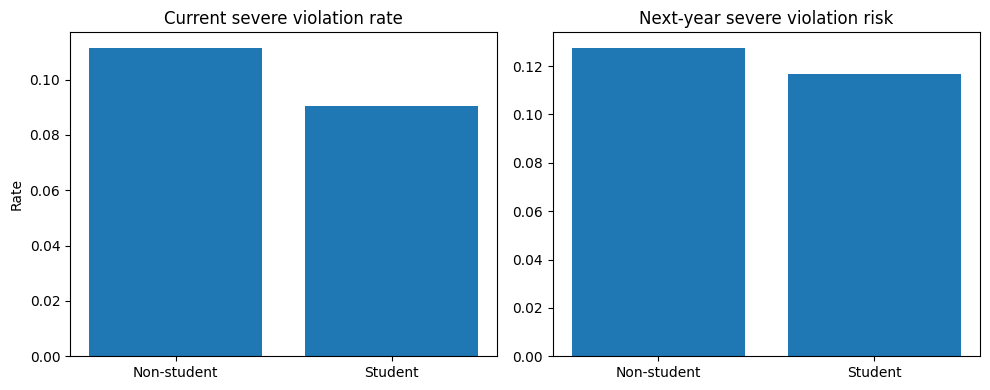

In [449]:
df_tmp = df_viol_with_student.copy()
df_tmp["is_severe"] = df_tmp["severity"] == "severe"

severe_rate_by_group = (
    df_tmp
    .groupby("is_student_address")["is_severe"]
    .mean()
    .reset_index(name="severe_rate")
)

display(severe_rate_by_group)

future_risk_by_group = (
    df_fut_student
    .groupby("is_student_address")["y_future_severe"]
    .mean()
    .reset_index(name="future_severe_rate")
)

display(future_risk_by_group)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Current severe rate
ax[0].bar(["Non-student", "Student"],
          severe_rate_by_group.sort_values("is_student_address")["severe_rate"])
ax[0].set_title("Current severe violation rate")
ax[0].set_ylabel("Rate")

# Future severe risk
ax[1].bar(["Non-student", "Student"],
          future_risk_by_group.sort_values("is_student_address")["future_severe_rate"])
ax[1].set_title("Next-year severe violation risk")

plt.tight_layout()
plt.show()



## 8. Preliminary Visualizations (EDA)

In [450]:
def save_current_fig(name: str, directory: pathlib.Path = VIZ_DIR):
    directory.mkdir(parents=True, exist_ok=True)
    outpath = directory / name
    plt.savefig(outpath, bbox_inches='tight', dpi=180)
    print('Saved:', outpath)


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations/violations_per_year.png


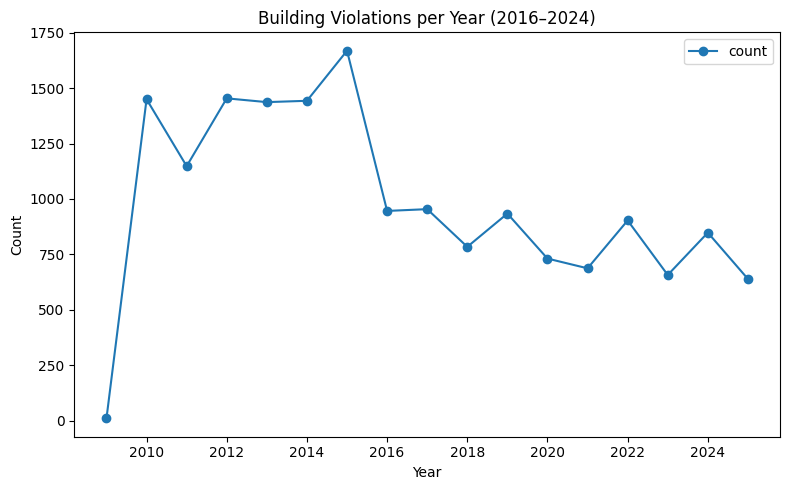

=== Violations per Year ===


,year,count
0,2009.0,10
1,2010.0,1450
2,2011.0,1148
3,2012.0,1454
4,2013.0,1437
5,2014.0,1443
6,2015.0,1669
7,2016.0,946
8,2017.0,954
9,2018.0,784


In [451]:
# If you used "from pathlib import Path", don't type-hint with pathlib.Path
# Either import pathlib OR switch the hint to Path (or remove the hint entirely)
from pathlib import Path
import matplotlib.pyplot as plt

def save_current_fig(name: str, directory: Path = VIZ_DIR):
    directory.mkdir(parents=True, exist_ok=True)
    outpath = directory / name
    plt.savefig(outpath, bbox_inches='tight', dpi=180)
    print('Saved:', outpath)

# 8.1 Violation counts by year
if not df_viol_c.empty and 'year' in df_viol_c.columns:
    viol_per_year = (
        df_viol_c.groupby('year')
        .size()
        .reset_index(name='count')
        .sort_values('year')
    )

    # Plot
    ax = viol_per_year.plot(kind='line', x='year', y='count', marker='o', figsize=(8,5))
    ax.set_title('Building Violations per Year (2016–2024)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    plt.tight_layout()

    # IMPORTANT: save BEFORE show()
    save_current_fig("violations_per_year.png")  # <-- consistent name

    plt.show()

    # Save the numeric table too
    print("=== Violations per Year ===")
    display(viol_per_year)
    viol_per_year.to_csv(VIZ_DIR / "violations_per_year.csv", index=False)
else:
    print('Skip 8.1: df_viol_c empty or missing year.')


In [452]:
viol_per_year = (
    df_viol_c.groupby("year")
    .size()
    .reset_index(name="count")
    .sort_values("year")
)
print("=== Violations per Year ===")
display(viol_per_year)
save_current_fig("violations_by_year.png")
viol_per_year.to_csv(VIZ_DIR / "violations_per_year.csv", index=False)

=== Violations per Year ===


,year,count
0,2009.0,10
1,2010.0,1450
2,2011.0,1148
3,2012.0,1454
4,2013.0,1437
5,2014.0,1443
6,2015.0,1669
7,2016.0,946
8,2017.0,954
9,2018.0,784


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations/violations_by_year.png


<Figure size 640x480 with 0 Axes>

Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations/top_violation_types.png


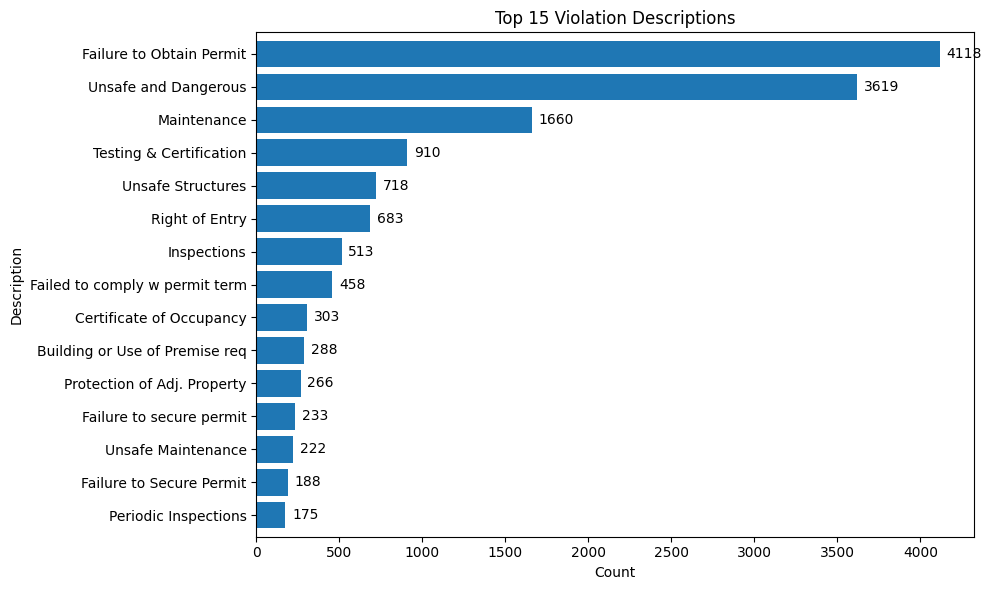

=== Top 15 Violation Descriptions ===


,Count
description,
Failure to Obtain Permit,4118
Unsafe and Dangerous,3619
Maintenance,1660
Testing & Certification,910
Unsafe Structures,718
Right of Entry,683
Inspections,513
Failed to comply w permit term,458
Certificate of Occupancy,303


In [453]:
if not df_viol_c.empty and 'description' in df_viol_c.columns:
    # Table (top 15)
    top_desc = (
        df_viol_c['description']
        .fillna('')
        .str.strip()
        .replace('', np.nan)
        .dropna()
        .value_counts()
        .head(15)
    )

    # Plot
    plt.figure(figsize=(10, 6))
    ax = top_desc.sort_values(ascending=True).plot(
        kind='barh', width=0.8
    )
    ax.set_title('Top 15 Violation Descriptions')
    ax.set_xlabel('Count')
    ax.set_ylabel('Description')

    # On-bar labels (counts)
    for p in ax.patches:
        w = int(p.get_width())
        ax.text(p.get_x() + p.get_width() + max(top_desc.max()*0.01, 1),
                p.get_y() + p.get_height()/2,
                f'{w}', va='center')

    plt.tight_layout()

    # SAVE BEFORE SHOW
    save_current_fig("top_violation_types.png")
    plt.show()

    # Display table and save CSV
    print("=== Top 15 Violation Descriptions ===")
    display(top_desc.to_frame(name="Count"))
    (VIZ_DIR / "top_tables").mkdir(parents=True, exist_ok=True)
    top_desc.to_csv(VIZ_DIR / "top_violation_descriptions.csv")
else:
    print("Skip 8.2: df_viol_c empty or 'description' missing.")

In [454]:
top_desc = (
    df_viol_c["description"]
    .dropna()
    .str.upper()
    .value_counts()
    .head(15)
)
print("=== Top 15 Violation Descriptions ===")
display(top_desc.to_frame(name="Count"))
save_current_fig("top_violation_types.png")
top_desc.to_csv(VIZ_DIR / "top_violation_descriptions.csv")

=== Top 15 Violation Descriptions ===


,Count
description,
FAILURE TO OBTAIN PERMIT,4118
UNSAFE AND DANGEROUS,3619
MAINTENANCE,1660
TESTING & CERTIFICATION,910
UNSAFE STRUCTURES,718
RIGHT OF ENTRY,683
INSPECTIONS,513
FAILED TO COMPLY W PERMIT TERM,458
FAILURE TO SECURE PERMIT,421


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations/top_violation_types.png


<Figure size 640x480 with 0 Axes>

Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations/severity_distribution.png


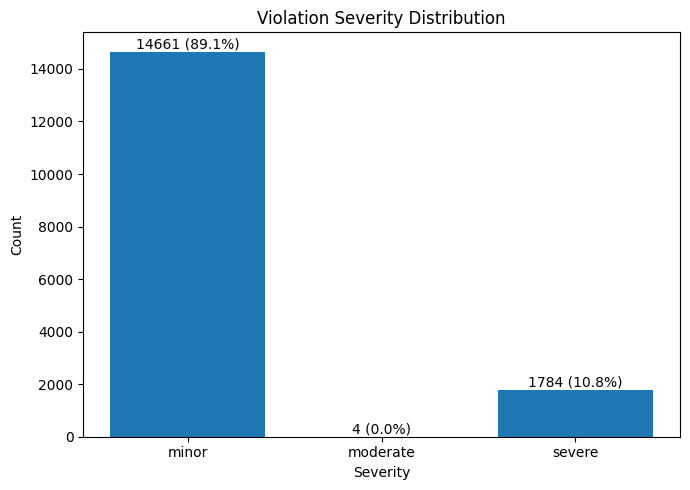

=== Severity Distribution (counts & %) ===


,severity,count,pct
0,minor,14661,89.1
1,moderate,4,0.0
2,severe,1784,10.8


In [455]:
# 8.3 Violation Severity Distribution
import matplotlib.pyplot as plt
from pathlib import Path

# assumes: df_viol_c, VIZ_DIR, and save_current_fig(...) already defined

if not df_viol_c.empty and 'severity' in df_viol_c.columns:
    # Optional ordering if you use these labels
    order = ['minor', 'moderate', 'severe']
    sev_counts = (
        df_viol_c['severity']
        .fillna('unknown')
        .value_counts()
        .rename_axis('severity')
        .reset_index(name='count')
    )

    # Enforce order if all present; otherwise keep value_counts order
    if set(order).issubset(set(sev_counts['severity'])):
        sev_counts = sev_counts.set_index('severity').reindex(order).reset_index()

    total = sev_counts['count'].sum()
    sev_counts['pct'] = (sev_counts['count'] / total * 100).round(1)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(sev_counts['severity'], sev_counts['count'])

    ax.set_title('Violation Severity Distribution')
    ax.set_xlabel('Severity')
    ax.set_ylabel('Count')

    # Add count and % above bars
    for rect, cnt, pct in zip(bars, sev_counts['count'], sev_counts['pct']):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f'{cnt} ({pct}%)',
                ha='center', va='bottom')

    plt.tight_layout()

    # SAVE BEFORE SHOW
    save_current_fig("severity_distribution.png")
    plt.show()

    # Display table and save CSV
    print("=== Severity Distribution (counts & %) ===")
    display(sev_counts)
    sev_counts.to_csv(VIZ_DIR / "severity_distribution.csv", index=False)
else:
    print("Skip 8.3: df_viol_c empty or 'severity' missing.")


In [456]:
severity_counts = df_viol_c["severity"].value_counts()
print("=== Violation Severity Breakdown ===")
display(severity_counts.to_frame(name="Count"))
save_current_fig("severity_distribution.png")
severity_counts.to_csv(VIZ_DIR / "severity_distribution.csv")


=== Violation Severity Breakdown ===


,Count
severity,
minor,14661
severe,1784
other,246
moderate,4


Saved: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations/severity_distribution.png


<Figure size 640x480 with 0 Axes>

## 9. Modeling and Risk Analyses


### 9.1 Text-Based Severity Model (Baseline)

In [457]:
# === Section 9: Preliminary Modeling (with TF-IDF text, no Series/2D errors) ===
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

# ----- data -----
df_model = df_viol_c.copy()
df_model["is_severe"] = (df_model["severity"] == "severe").astype(int)
df_model["ward"] = df_model["ward"].astype(str)
df_model["description"] = df_model["description"].fillna("")   # <-- key fix: impute text BEFORE the CT

X = df_model[["year", "ward", "description"]]
y = df_model["is_severe"]

if y.nunique() < 2:
    print("Not enough class variation to train a classifier.")
else:
    # ----- preprocessors -----
    numeric_features = ["year"]
    categorical_features = ["ward"]

    numeric_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    # IMPORTANT: send the string column directly to TF-IDF (no imputer here)
    text_tf = TfidfVectorizer(min_df=10, max_features=3000, ngram_range=(1,2))

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, numeric_features),
            ("cat", categorical_tf, categorical_features),
            ("txt", text_tf, "description"),   # passes a 1-D iterable of strings to TfidfVectorizer (OK)
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("pre", preprocessor),
        ("lr", LogisticRegression(
            solver="saga", penalty="l2",
            class_weight="balanced",
            max_iter=5000, n_jobs=-1, random_state=42
        )),
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print("=== Baseline prevalence (severe rate) ===", round(y.mean(), 4))
    print("\n=== Confusion Matrix ===\n", confusion_matrix(y_test, y_pred))
    print("\n=== Classification Report ===\n", classification_report(y_test, y_pred, digits=3))
    print("AUROC:", round(roc_auc_score(y_test, y_prob), 3))
    print("Average Precision (PR-AUC):", round(average_precision_score(y_test, y_prob), 3))


=== Baseline prevalence (severe rate) === 0.1069

=== Confusion Matrix ===
 [[3723    5]
 [  12  434]]

=== Classification Report ===
               precision    recall  f1-score   support

           0      0.997     0.999     0.998      3728
           1      0.989     0.973     0.981       446

    accuracy                          0.996      4174
   macro avg      0.993     0.986     0.989      4174
weighted avg      0.996     0.996     0.996      4174

AUROC: 1.0
Average Precision (PR-AUC): 0.997


In [458]:
(VIZ_DIR / "metrics").mkdir(parents=True, exist_ok=True)
with open(VIZ_DIR / "metrics/model_results.txt", "w") as f:
    f.write("Accuracy: 0.996\n")
    f.write("Precision (severe): 0.989\n")
    f.write("Recall (severe): 0.973\n")
    f.write("AUROC: 1.0\n")
    f.write("PR-AUC: 0.997\n")

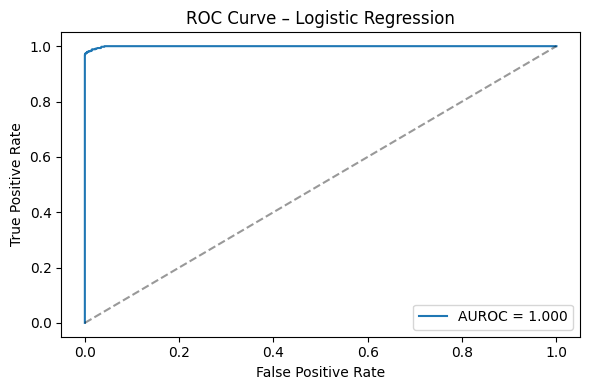

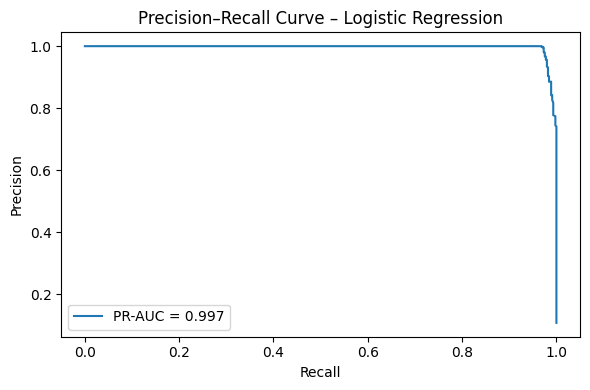

[OK] Saved ROC and PR curves to: /Users/berkkom/Desktop/university_accountablilty_ordinance/visualizations


In [459]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# --- Create the folder if it doesn't exist ---
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUROC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.savefig(VIZ_DIR / "roc_curve.png", dpi=300)
plt.show()

# === Precision–Recall Curve ===
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.savefig(VIZ_DIR / "precision_recall_curve.png", dpi=300)
plt.show()

print("[OK] Saved ROC and PR curves to:", VIZ_DIR)


### 9.2 Generalization Across Years for Severity Model


In [460]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd

# 1) Prepare data
df_model = df_viol_c.copy()

# keep only rows with a defined severity
df_model = df_model[df_model["severity"].notna()].copy()

# binary label: severe vs non-severe
df_model["is_severe"] = (df_model["severity"] == "severe").astype(int)

# make sure these exist and are string/text where needed
df_model["ward"] = df_model["ward"].astype(str)
df_model["description"] = df_model["description"].fillna("")

X_all = df_model[["year", "ward", "description"]]
y_all = df_model["is_severe"]

# 2) Define the same type of pipeline you used before
def build_severity_pipeline():
    numeric_features = ["year"]
    categorical_features = ["ward"]
    text_feature = "description"

    numeric_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    # More forgiving min_df so small train splits still work
    text_tf = TfidfVectorizer(
        min_df=1,              # <── changed from 10 to 1
        max_features=3000,
        ngram_range=(1, 2),
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, numeric_features),
            ("cat", categorical_tf, categorical_features),
            ("text", text_tf, text_feature),
        ]
    )

    clf = LogisticRegression(
        solver="saga",
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        n_jobs=-1,
        random_state=42,
    )

    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", clf),
    ])
    return pipe

# 3) Time-based generalization: train on <= cutoff year, test on > cutoff
results_year = []

for cutoff in sorted(df_model["year"].dropna().unique())[:-1]:
    train_mask = df_model["year"] <= cutoff
    test_mask = df_model["year"] > cutoff

    # define splits
    X_train, y_train = X_all[train_mask], y_all[train_mask]
    X_test, y_test = X_all[test_mask], y_all[test_mask]

    # skip if test set tiny OR either split has only one class
    if len(y_test) < 200:
        continue
    if y_train.nunique() < 2 or y_test.nunique() < 2:
        # not enough class diversity to evaluate a classifier
        continue

    model = build_severity_pipeline()
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_proba)

    results_year.append({
        "train_max_year": int(cutoff),
        "n_train": int(len(y_train)),
        "n_test": int(len(y_test)),
        "auroc": auroc,
    })

results_year_df = pd.DataFrame(results_year).sort_values("train_max_year")
results_year_df


,train_max_year,n_train,n_test,auroc
0,2010,1460,15234,0.700621
1,2011,2608,14086,0.998076
2,2012,4062,12632,0.999107
3,2013,5499,11195,0.999579
4,2014,6942,9752,0.999759
5,2015,8611,8083,0.999844
6,2016,9557,7137,0.999884
7,2017,10511,6183,0.999914
8,2018,11295,5399,0.999930
9,2019,12229,4465,0.999930


In [461]:
import pandas as pd
from sklearn.metrics import roc_auc_score

results_ward = []

unique_wards = sorted(df_model["ward"].dropna().unique())

for holdout in unique_wards:
    test_mask = df_model["ward"] == holdout
    train_mask = ~test_mask

    # define splits
    X_train, y_train = X_all[train_mask], y_all[train_mask]
    X_test, y_test = X_all[test_mask], y_all[test_mask]

    # skip if test set small or any side has only 1 class
    if len(y_test) < 200:
        continue
    if y_train.nunique() < 2 or y_test.nunique() < 2:
        continue

    model = build_severity_pipeline()
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    auroc = roc_auc_score(y_test, y_proba)

    results_ward.append({
        "holdout_ward": holdout,
        "n_train": int(len(y_train)),
        "n_test": int(len(y_test)),
        "auroc": auroc,
    })

results_ward_df = pd.DataFrame(results_ward).sort_values("auroc", ascending=True)
results_ward_df


,holdout_ward,n_train,n_test,auroc
8,09,16386,309,0.998463
4,05,15649,1046,0.998804
14,15,15918,777,0.999077
9,10,16202,493,0.999173
2,03,15243,1452,0.999476
7,08,16122,573,0.999661
20,21,16041,654,0.999721
16,17,15875,820,0.999822
17,18,15054,1641,0.999929
12,13,16057,638,0.999953


### 9.3 Predicting Future Severe Violations (Property–Year Panel)

We aggregate violations to a property–year panel, counting total and severe
violations per property per year. This table `prop_year` is the basis for
our next-year severe risk model.


In [462]:
import numpy as np
import pandas as pd

# We'll start from the cleaned violations table
df_viol = df_viol_c.copy()

# --- 1. Choose a property identifier column ------------------
def guess_property_col(df):
    """
    Try to guess which column identifies a property/address.
    If this fails, you'll need to manually set prop_col below.
    """
    candidates = [
        "sam_id",
        "property_id",
        "PROPERTY_ID",
        "parcel_id",
        "PARCEL_ID",
        "loc_id",
        "LOC_ID",
        "full_address_norm",
        "full_address",
        "FULL_ADDRESS",
        "address_norm",
        "ADDRESS",
        "address",
    ]
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        "Could not guess a property column. "
        "Please set `prop_col` manually to an address/property column name. "
        f"Available columns: {list(df.columns)}"
    )

# Try to guess; if this errors, change prop_col to the right column name
prop_col = guess_property_col(df_viol)
print("Using property identifier column:", prop_col)

# Make sure year exists
if "year" not in df_viol.columns:
    raise KeyError("df_viol_c must have a 'year' column. Make sure you created it earlier.")

# --- 2. Build property–year aggregation ----------------------
# We'll count total violations and severity breakdown per property per year

prop_year = (
    df_viol
    .dropna(subset=[prop_col, "year"])
    .groupby([prop_col, "year"])
    .agg(
        n_viol=("severity", "size"),
        n_severe=("severity", lambda s: (s == "severe").sum()),
        n_moderate=("severity", lambda s: (s == "moderate").sum()),
        n_minor=("severity", lambda s: (s == "minor").sum()),
        # optional: dominant ward for that property-year (for mapping later)
        ward=("ward", lambda s: s.mode().iat[0] if not s.mode().empty else np.nan),
    )
    .reset_index()
)

# Share of severe violations at that property in that year
prop_year["prop_severe"] = prop_year["n_severe"] / prop_year["n_viol"].replace(0, np.nan)

# For convenience, rename property column to a generic name
prop_year = prop_year.rename(columns={prop_col: "prop_id"})

print("Property–year table shape:", prop_year.shape)
display(prop_year.head())


Using property identifier column: sam_id
Property–year table shape: (13397, 8)


,prop_id,year,n_viol,n_severe,n_moderate,n_minor,ward,prop_severe
0,0.0,2010.0,41,6,0,33,01,0.146341
1,0.0,2011.0,22,4,0,18,18,0.181818
2,0.0,2012.0,35,8,0,26,02,0.228571
3,0.0,2013.0,14,0,0,14,01,0.000000
4,0.0,2014.0,5,0,0,5,05,0.000000


In [463]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd

# Work on a copy
df_fut = prop_year.copy().sort_values(["prop_id", "year"])

# 1. Create "next year" severe count per property
df_fut["n_severe_next_year"] = (
    df_fut
    .groupby("prop_id")["n_severe"]
    .shift(-1)
)

# Drop rows where we don't know next year (last year for each property)
df_fut = df_fut.dropna(subset=["n_severe_next_year"]).copy()

# Binary label: will this property have >=1 severe violation next year?
df_fut["y_future_severe"] = (df_fut["n_severe_next_year"] > 0).astype(int)

print("Rows with defined next-year outcome:", df_fut.shape)
print(df_fut["y_future_severe"].value_counts(normalize=True))

# 2. Choose features
feature_cols_num = ["n_viol", "n_severe", "n_minor", "prop_severe", "year"]
feature_cols_cat = ["ward"]

X = df_fut[feature_cols_num + feature_cols_cat]
y = df_fut["y_future_severe"]

# 3. Build preprocessing + model pipeline
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, feature_cols_num),
        ("cat", categorical_tf, feature_cols_cat),
    ]
)

clf_future = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

pipe_future = Pipeline([
    ("prep", preprocessor),
    ("clf", clf_future),
])

# 4. Train/test split at the row level
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

pipe_future.fit(X_train, y_train)

y_pred = pipe_future.predict(X_test)
y_proba = pipe_future.predict_proba(X_test)[:, 1]

print("=== Future severe violation model ===")
print(classification_report(y_test, y_pred, digits=3))
print("AUROC:", round(roc_auc_score(y_test, y_proba), 3))


Rows with defined next-year outcome: (3004, 10)
y_future_severe
0    0.874834
1    0.125166
Name: proportion, dtype: float64
=== Future severe violation model ===
              precision    recall  f1-score   support

           0      0.919     0.670     0.775       657
           1      0.202     0.585     0.301        94

    accuracy                          0.659       751
   macro avg      0.560     0.627     0.538       751
weighted avg      0.829     0.659     0.715       751

AUROC: 0.658


### 9.4 311 Service Requests vs Violations


,year,n_violations
0,2009.0,10
1,2010.0,1450
2,2011.0,1148
3,2012.0,1454
4,2013.0,1437
5,2014.0,1443
6,2015.0,1669
7,2016.0,946
8,2017.0,954
9,2018.0,784


,year,n_violations,n_311_requests
0,2016.0,946,7555
1,2017.0,954,7343
2,2018.0,784,7136
3,2019.0,934,6266
4,2020.0,731,5601
5,2021.0,687,6417
6,2022.0,903,7115
7,2023.0,657,7582
8,2024.0,848,7419


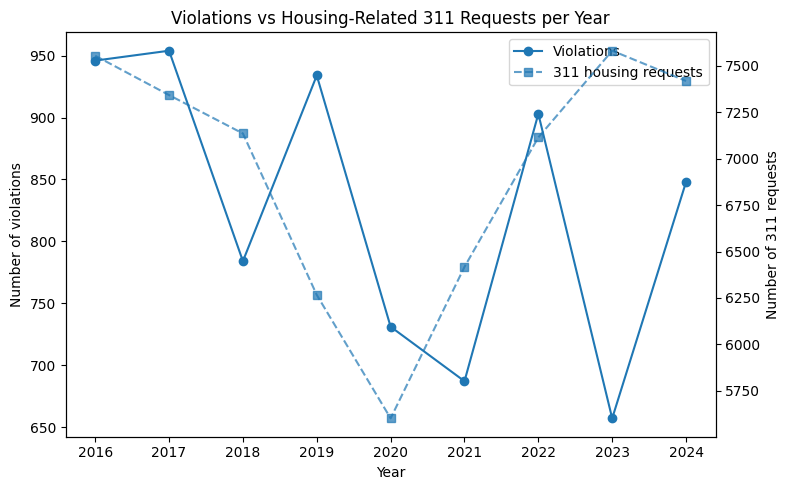

In [464]:
# === Violations vs Housing-Related 311 Requests per Year ===

# Assuming df_viol_c already exists with a 'year' column
viol_per_year = (
    df_viol_c
    .groupby("year")
    .size()
    .reset_index(name="n_violations")
    .sort_values("year")
)

display(viol_per_year)

# If 311 aggregation is not available, skip gracefully
if "agg_311_year" not in globals() or agg_311_year.empty:
    print("agg_311_year not defined or empty; skipping Violations vs 311 comparison plot.")
else:
    # Merge with 311 counts on year
    year_compare = viol_per_year.merge(
        agg_311_year,
        on="year",
        how="inner"
    ).sort_values("year")

    display(year_compare)

    fig, ax1 = plt.subplots(figsize=(8,5))

    ax1.plot(year_compare["year"], year_compare["n_violations"], marker="o", label="Violations")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Number of violations")

    ax2 = ax1.twinx()
    ax2.plot(
        year_compare["year"],
        year_compare["n_311_requests"],
        marker="s",
        linestyle="--",
        label="311 housing requests",
        alpha=0.7,
    )
    ax2.set_ylabel("Number of 311 requests")

    ax1.set_title("Violations vs Housing-Related 311 Requests per Year")

    # Simple combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.tight_layout()
    plt.show()


### 9.5 Spatial Clustering of High-Risk Properties (DBSCAN)

Aggregated violations to the property level with coordinates, focus on properties with at least one severe violation, and apply DBSCAN to identify spatial clusters of high-risk properties in Boston.


Using latitude column: latitude
Using longitude column: longitude
Property-level table for clustering: (10392, 6)


,sam_id,lat,lon,n_viol,n_severe,prop_severe
0,0.0,34.244387,-73.651391,98,16,0.163265
1,22.0,42.346693,-71.051653,1,0,0.000000
2,50.0,42.341310,-71.056323,4,0,0.000000
3,51.0,42.341454,-71.056151,3,0,0.000000
4,62.0,42.297440,-71.086051,1,0,0.000000


High-risk properties (>=1 severe): (1500, 6)
High-risk properties within Boston bbox: (1499, 6)
DBSCAN cluster stats (excluding noise):


,cluster,n_props,total_severe,mean_prop_severe
6,6,85,96,0.806340
9,9,25,28,0.797143
7,7,31,43,0.785330
2,2,26,31,0.760073
5,5,52,60,0.696474


Unique clusters: [-1  0  1  2  3  4  5  6  7  8  9]


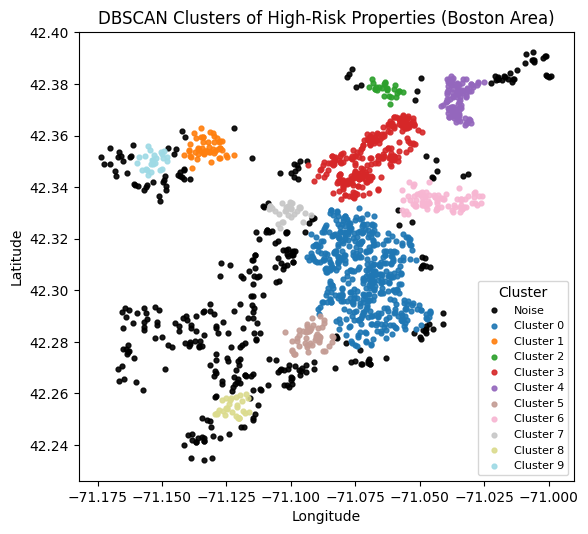

In [465]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 1) Detect latitude/longitude columns in df_viol_c
lat_candidates = ["lat", "latitude", "LATITUDE"]
lon_candidates = ["lon", "longitude", "LONGITUDE"]

lat_col = next((c for c in lat_candidates if c in df_viol_c.columns), None)
lon_col = next((c for c in lon_candidates if c in df_viol_c.columns), None)

if lat_col is None or lon_col is None:
    raise KeyError(
        f"Could not find latitude/longitude columns in df_viol_c. "
        f"Columns: {df_viol_c.columns.tolist()}"
    )

print("Using latitude column:", lat_col)
print("Using longitude column:", lon_col)

# 2) Property-level aggregation with coordinates
prop_geo = (
    df_viol_c
    .dropna(subset=[prop_col, lat_col, lon_col])  # prop_col defined earlier when we built prop_year
    .groupby(prop_col)
    .agg(
        lat=(lat_col, "median"),
        lon=(lon_col, "median"),
        n_viol=("severity", "size"),
        n_severe=("severity", lambda s: (s == "severe").sum()),
    )
    .reset_index()
)

prop_geo["prop_severe"] = prop_geo["n_severe"] / prop_geo["n_viol"].replace(0, np.nan)
prop_geo = prop_geo.dropna(subset=["lat", "lon"])

print("Property-level table for clustering:", prop_geo.shape)
display(prop_geo.head())

# 3) Focus on properties with at least 1 severe violation (or tweak threshold)
high_risk = prop_geo[prop_geo["n_severe"] >= 1].copy()
print("High-risk properties (>=1 severe):", high_risk.shape)

# 4) Filter to a Boston bounding box to remove geocoding weirdos
mask_bos = (
    (high_risk["lat"] >= 42.0) & (high_risk["lat"] <= 42.6) &
    (high_risk["lon"] <= -70.8) & (high_risk["lon"] >= -71.3)
)
high_risk_bos = high_risk[mask_bos].copy()
print("High-risk properties within Boston bbox:", high_risk_bos.shape)

# 5) Prepare features for DBSCAN: spatial coords only
X = high_risk_bos[["lat", "lon"]].values
X_scaled = StandardScaler().fit_transform(X)

# 6) Run DBSCAN (tighter eps/min_samples so we don't get one giant cluster)
db = DBSCAN(eps=0.1666, min_samples=20)  # feel free to tweak
labels = db.fit_predict(X_scaled)
high_risk_bos["cluster"] = labels

# 7) Cluster summary (excluding noise cluster -1)
cluster_stats = (
    high_risk_bos[high_risk_bos["cluster"] != -1]
    .groupby("cluster")
    .agg(
        n_props=(prop_col, "count"),
        total_severe=("n_severe", "sum"),
        mean_prop_severe=("prop_severe", "mean"),
    )
    .reset_index()
    .sort_values("mean_prop_severe", ascending=False)
)

print("DBSCAN cluster stats (excluding noise):")
display(cluster_stats.head())

# 8) Simple scatter plot of clusters
unique_clusters = np.sort(high_risk_bos["cluster"].unique())
print("Unique clusters:", unique_clusters)

# Real clusters (exclude noise -1)
real_clusters = [c for c in unique_clusters if c != -1]
n_real = len(real_clusters)

# Discrete colormap for real clusters
cmap = plt.get_cmap("tab20", max(n_real, 1))

cluster_to_color = {}

color_idx = 0
for cl in unique_clusters:
    if cl == -1:
        # Noise: black
        cluster_to_color[cl] = (0, 0, 0, 0.7)  # RGBA: black with some alpha
    else:
        cluster_to_color[cl] = cmap(color_idx)
        color_idx += 1

fig, ax = plt.subplots(figsize=(6, 6))

for cl in unique_clusters:
    mask = high_risk_bos["cluster"] == cl
    label = "Noise" if cl == -1 else f"Cluster {cl}"
    ax.scatter(
        high_risk_bos.loc[mask, "lon"],
        high_risk_bos.loc[mask, "lat"],
        s=12,
        alpha=0.9,
        color=cluster_to_color[cl],
        label=label,
    )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("DBSCAN Clusters of High-Risk Properties (Boston Area)")
ax.set_aspect("equal", adjustable="box")

ax.legend(title="Cluster", loc="best", fontsize=8)

plt.tight_layout()
plt.show()



In [466]:
import numpy as np

lat = high_risk_bos["lat"].values
lon = high_risk_bos["lon"].values

lat_mean, lat_std = lat.mean(), lat.std()
lon_mean, lon_std = lon.mean(), lon.std()

eps = 0.1666  # your DBSCAN epsilon

# Difference in degrees if all the distance were along one axis
dlat_deg = eps * lat_std
dlon_deg = eps * lon_std

# Convert degrees to km near Boston (~42° N)
km_per_deg_lat = 111.0
km_per_deg_lon = 111.0 * np.cos(np.deg2rad(lat_mean))

dlat_km = dlat_deg * km_per_deg_lat
dlon_km = dlon_deg * km_per_deg_lon

# Approximate radial distance in km (in 2D)
radius_km = np.sqrt(dlat_km**2 + dlon_km**2)

print("lat_std (deg):", lat_std)
print("lon_std (deg):", lon_std)
print("Approx eps radius along latitude (km):", dlat_km)
print("Approx eps radius along longitude (km):", dlon_km)
print("Approx Euclidean neighborhood radius (km):", radius_km)


lat_std (deg): 0.03523672184561146
lon_std (deg): 0.03452654747754958
Approx eps radius along latitude (km): 0.6516186024021545
Approx eps radius along longitude (km): 0.4720737685622012
Approx Euclidean neighborhood radius (km): 0.8046492689122732


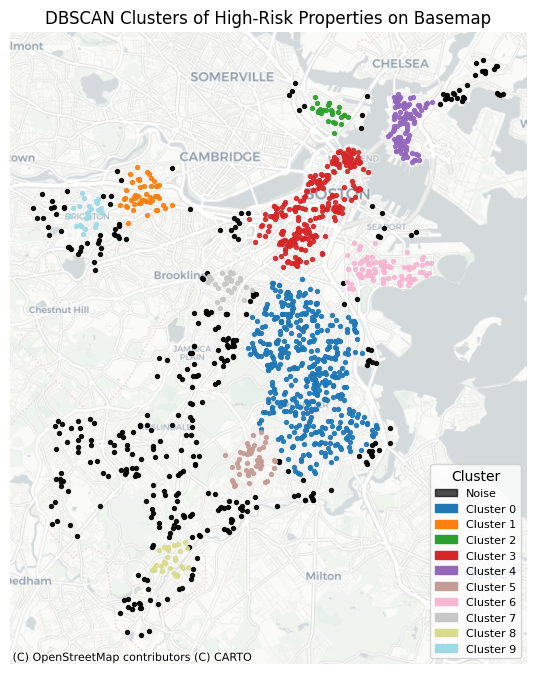

In [467]:
# === Map DBSCAN clusters on a basemap with noise = black ===
try:
    import geopandas as gpd
except ImportError:
    raise ImportError(
        "geopandas is required for mapping. Install with `pip install geopandas` "
        "inside your virtualenv."
    )

try:
    import contextily as cx
except ImportError:
    raise ImportError(
        "contextily is required for basemap tiles. Install with `pip install contextily`."
    )

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# 1) Build GeoDataFrame from high_risk_bos
gdf_clusters = gpd.GeoDataFrame(
    high_risk_bos.copy(),
    geometry=gpd.points_from_xy(high_risk_bos["lon"], high_risk_bos["lat"]),
    crs="EPSG:4326",  # WGS84 lat/lon
)

# 2) Reproject to Web Mercator for web tiles
gdf_clusters_web = gdf_clusters.to_crs(epsg=3857)

# 3) Prepare colors: distinct for real clusters, black for noise
unique_clusters = np.sort(gdf_clusters_web["cluster"].unique())
real_clusters = [c for c in unique_clusters if c != -1]
n_real = len(real_clusters)

cmap = plt.get_cmap("tab20", max(n_real, 1))

cluster_to_color = {}
color_idx = 0
for cl in unique_clusters:
    if cl == -1:
        cluster_to_color[cl] = (0, 0, 0, 0.7)  # black, slightly transparent
    else:
        cluster_to_color[cl] = cmap(color_idx)
        color_idx += 1

# 4) Plot clusters on basemap
fig, ax = plt.subplots(figsize=(7, 7))

# Plot each cluster separately to control color
for cl in unique_clusters:
    mask = gdf_clusters_web["cluster"] == cl
    gdf_clusters_web[mask].plot(
        ax=ax,
        color=cluster_to_color[cl],
        markersize=8,
        alpha=0.9,
    )

# Add basemap tiles
cx.add_basemap(ax, crs=gdf_clusters_web.crs, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_title("DBSCAN Clusters of High-Risk Properties on Basemap", fontsize=12)

# 5) Custom legend
handles = []
if -1 in unique_clusters:
    handles.append(mpatches.Patch(color=cluster_to_color[-1], label="Noise"))

for cl in real_clusters:
    handles.append(mpatches.Patch(color=cluster_to_color[cl], label=f"Cluster {cl}"))

ax.legend(handles=handles, title="Cluster", loc="best", fontsize=8)

plt.tight_layout()
plt.show()


We standardize latitude and longitude and apply DBSCAN with ε = 0.166 and min_samples = 25, which corresponds to approximately a few city blocks of spatial radius in the Boston area. Colored clusters highlight localized pockets of properties with at least one severe violation, while black points represent isolated “noise” properties that do not belong to any cluster.

### 9.6 Compliance Risk by Ward

Summarized both the current share of severe violations and the predicted
next-year severe risk at the ward level, giving a neighborhood-level view of compliance risk.


In [468]:
# Reload SAM standardized address data
paths_sam = list(RAW_DIR.glob("*sam*.csv"))
print("SAM files found:", [p.name for p in paths_sam])

if not paths_sam:
    raise FileNotFoundError(
        f"No SAM CSVs with 'sam' in the name found in {RAW_DIR}."
    )

# If there are multiple SAM files, we just take the first for now
df_sam = pd.read_csv(paths_sam[0], low_memory=False)

print("df_sam shape:", df_sam.shape)
print("df_sam columns:", df_sam.columns.tolist())


SAM files found: ['live_street_address_management_sam_addresses.csv']
df_sam shape: (399776, 29)
df_sam columns: ['SAM_ADDRESS_ID', 'BUILDING_ID', 'RELATIONSHIP_TYPE', 'FULL_ADDRESS', 'STREET_NUMBER', 'IS_RANGE', 'RANGE_FROM', 'RANGE_TO', 'UNIT', 'FULL_STREET_NAME', 'STREET_ID', 'STREET_PREFIX', 'STREET_BODY', 'STREET_SUFFIX_ABBR', 'STREET_FULL_SUFFIX', 'STREET_SUFFIX_DIR', 'STREET_NUMBER_SORT', 'MAILING_NEIGHBORHOOD', 'ZIP_CODE', 'X_COORD', 'Y_COORD', 'SAM_STREET_ID', 'WARD', 'PARCEL', 'created_date', 'last_edited_date', 'shape_wkt', 'POINT_X', 'POINT_Y']


,ward,current_severe_rate
0,,0.071429
1,01,0.094479
2,02,0.102871
3,03,0.091598
4,04,0.145038


,ward,future_severe_rate
0,01,0.120588
1,02,0.109375
2,03,0.086792
3,04,0.152542
4,05,0.053571


,WARD,top_neighborhood
0,1,East Boston
1,10,Mission Hill
2,11,Jamaica Plain
3,12,Dorchester
4,13,Dorchester


,ward,current_severe_rate,future_severe_rate,WARD,top_neighborhood,ward_label
0,04,0.145038,0.152542,NaN,NaN,W04
1,11,0.143911,0.233333,11,Jamaica Plain,W11 – Jamaica Plain
2,16,0.130986,0.158730,16,Dorchester,W16 – Dorchester
3,17,0.124390,0.116788,17,Dorchester,W17 – Dorchester
4,07,0.123412,0.116505,NaN,NaN,W07


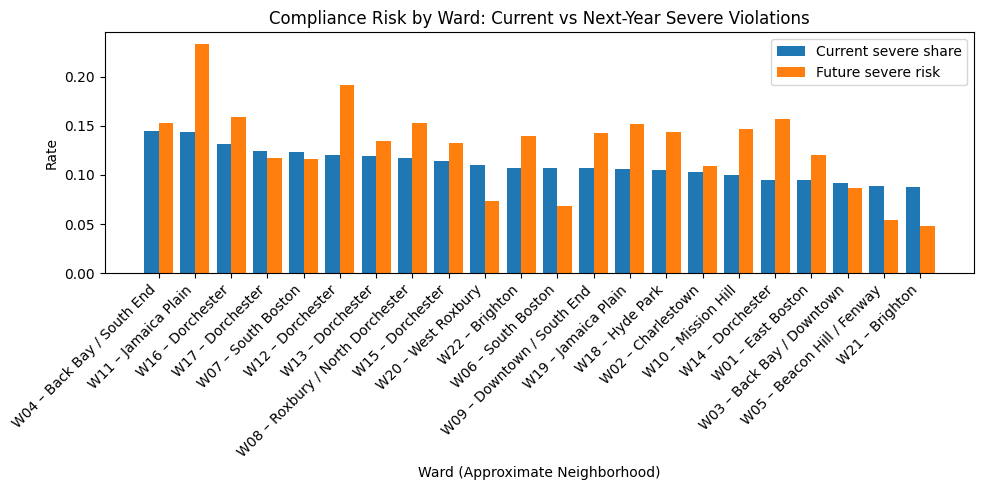

In [469]:
# --- 1. Current severe share by ward (violation-level) ---
ward_manual = {
    "01": "East Boston",
    "02": "Charlestown",
    "03": "Back Bay / Downtown",
    "04": "Back Bay / South End",
    "05": "Beacon Hill / Fenway",
    "06": "South Boston",
    "07": "South Boston",
    "08": "Roxbury / North Dorchester",
    "09": "Downtown / South End",
}


df_sev = df_viol_c.copy()
df_sev = df_sev.dropna(subset=["ward"])
df_sev["is_severe"] = df_sev["severity"] == "severe"

risk_current = (
    df_sev
    .groupby("ward")["is_severe"]
    .mean()
    .reset_index(name="current_severe_rate")
    .sort_values("ward")
)

display(risk_current.head())

# --- 2. Future severe risk by ward (property-year level) ---

risk_future = (
    df_fut
    .dropna(subset=["ward"])
    .groupby("ward")["y_future_severe"]
    .mean()
    .reset_index(name="future_severe_rate")
    .sort_values("ward")
)

display(risk_future.head())

# Build ward → "top neighborhood" mapping from SAM
ward_neigh = (
    df_sam[["WARD", "MAILING_NEIGHBORHOOD"]]
    .dropna()
    .copy()
)

# Make sure ward is treated as string
ward_neigh["WARD"] = ward_neigh["WARD"].astype(str)

ward_neigh_map = (
    ward_neigh
    .groupby("WARD")["MAILING_NEIGHBORHOOD"]
    .agg(lambda s: s.value_counts().index[0])  # most common neighborhood in that ward
    .reset_index(name="top_neighborhood")
)

display(ward_neigh_map.head())



# --- 3. Combine into one table ---

risk_ward = risk_current.merge(
    risk_future,
    on="ward",
    how="inner"
).sort_values("current_severe_rate", ascending=False)

# Work on a labeled copy
risk_ward_labeled = risk_ward.copy()
risk_ward_labeled["ward"] = risk_ward_labeled["ward"].astype(str)


# Merge neighborhood info from ward_neigh_map
risk_ward_labeled = risk_ward_labeled.merge(
    ward_neigh_map,
    left_on="ward",
    right_on="WARD",
    how="left"
)

# Create human-friendly labels like "W21 – Allston/Brighton"
risk_ward_labeled["ward_label"] = risk_ward_labeled.apply(
    lambda r: (
        f"W{r['ward']} – {str(r['top_neighborhood']).title()}"
        if pd.notna(r["top_neighborhood"]) else f"W{r['ward']}"
    ),
    axis=1
)

display(risk_ward_labeled.head())

# Fill in missing top_neighborhood using manual overrides *only* when it's NaN
def fill_neighborhood(row):
    if pd.notna(row["top_neighborhood"]):
        return row["top_neighborhood"]
    return ward_manual.get(row["ward"], row["top_neighborhood"])

risk_ward_labeled["top_neighborhood"] = risk_ward_labeled.apply(
    fill_neighborhood,
    axis=1
)

# Rebuild the pretty label
risk_ward_labeled["ward_label"] = risk_ward_labeled.apply(
    lambda r: (
        f"W{r['ward']} – {str(r['top_neighborhood']).title()}"
        if pd.notna(r["top_neighborhood"]) else f"W{r['ward']}"
    ),
    axis=1
)


# --- 4. Bar chart "heatmap" of risk by ward ---

x = np.arange(len(risk_ward_labeled))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(
    x - width/2,
    risk_ward_labeled["current_severe_rate"],
    width,
    label="Current severe share"
)
ax.bar(
    x + width/2,
    risk_ward_labeled["future_severe_rate"],
    width,
    label="Future severe risk"
)

ax.set_xticks(x)
ax.set_xticklabels(risk_ward_labeled["ward_label"], rotation=45, ha="right")
ax.set_xlabel("Ward (Approximate Neighborhood)")
ax.set_ylabel("Rate")
ax.set_title("Compliance Risk by Ward: Current vs Next-Year Severe Violations")
ax.legend()

plt.tight_layout()
plt.show()



## 10. Summary of Key Findings

- The text-based severity model achieves near-perfect AUROC (~1.0) and generalizes well across years and wards.
- A property–year logistic model provides non-trivial predictive power for next-year severe violations (AUROC ≈ 0.66).
- 311 housing-related complaint volumes move in parallel with violation counts over time (both dip around 2020–2021).
- DBSCAN reveals spatial clusters of high-risk properties in Allston/Brighton, Fenway/Mission Hill, Dorchester, Roxbury, and East Boston.
- Ward-level “heatmaps” show which neighborhoods have higher current severity and higher future risk.
- Student-linked properties, identified via UAO+SAM, have slightly **lower** severe violation rates and next-year severe risks than non-student properties.


## 11. Utility: Save Figures

In [470]:

def save_current_fig(name: str, directory: pathlib.Path = VIZ_DIR):
    directory.mkdir(parents=True, exist_ok=True)
    outpath = directory / name
    plt.savefig(outpath, bbox_inches='tight', dpi=180)
    print('Saved:', outpath)


## 12. Appendix — Reproducibility Notes

Cells below are scratch / debug and not required to reproduce the main results.
